In [3]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

In [ ]:
####################
# Results Summary  #
####################

# No significant difference by Obs * Manner of death
# No significant difference by Sha * Manner of death

#Significant difference by Obs * Organ

#Significant regression - decrease in observed richness * PMI for spleen only (no other organs significant)

#Significant regression - decrease in Shannon Index * PMI for spleen only (no other organs significant)

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


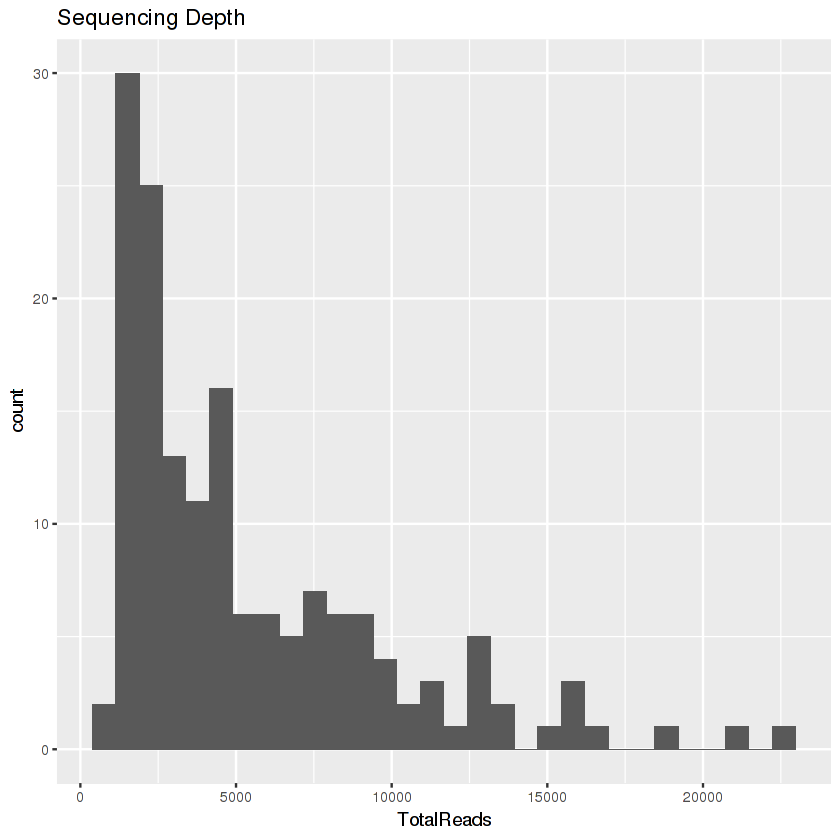

In [8]:
#Read in data
setwd("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/")

biom <- import_biom("all_cohorts_cadaver_deblur.biom")
map <- import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Ita.df.MOD.txt")
tree <- read_tree("rep_phylo.tre")
complete <- merge_phyloseq(biom,tree,map)
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))
#Subset to Italian data only
Ita = subset_samples(cadaver_nt, Location=="Italy")

#Estimate read depth
Ita_sdt = data.table(as(sample_data(Ita), "data.frame"),
                 TotalReads = sample_sums(Ita), keep.rownames = TRUE)
setnames(Ita_sdt, "rn", "SampleName")
pSeqDepth = ggplot(Ita_sdt, aes(TotalReads)) + geom_histogram() + ggtitle("Sequencing Depth")
pSeqDepth


In [9]:
Ita_sdt = data.table(as(sample_data(complete), "data.frame"),
                 TotalReads = sample_sums(complete), keep.rownames = TRUE)
#setnames(Ita_sdt, "rn", "SampleName")
#pSeqDepth = ggplot(Ita_sdt, aes(TotalReads)) + geom_histogram() + ggtitle("Sequencing Depth")
#pSeqDepth

x = sum(Ita_sdt$TotalReads)
x

[1] 853850

In [4]:
#By Organ

sample_tab = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/all_cadaver_metadata.csv")
colnames(sample_tab)[1] <- "SampleID"

obs = estimate_richness(na.omit(Ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Organ") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Organ")

stats.obs = dfobs %>%
    group_by(Organ) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) #%>%
    #arrange(-desc(mean))
stats.obs

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~Organ, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$Organ, method="bonferroni")
dunn

Organ,median,mean,sd,sem
Brain,36.0,39.31429,13.27707,2.244235
Heart,30.0,32.55172,13.58462,2.522600
Liver,38.5,44.41667,23.32304,3.887174
Prostate,95.0,105.42857,57.09078,12.458230
Spleen,45.5,49.20833,18.55188,3.786886
Uterus,83.0,91.46154,41.63655,11.547902



	Kruskal-Wallis rank sum test

data:  Observed by Organ
Kruskal-Wallis chi-squared = 54.043, df = 5, p-value = 2.054e-10


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 54.0429, df = 5, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Brain      Heart      Liver   Prostate     Spleen
---------+-------------------------------------------------------
   Heart |   1.888796
         |     0.4419
         |
   Liver |  -0.634952  -2.504854
         |     1.0000     0.0919
         |
Prostate |  -4.533245  -6.022258  -4.008123
         |    0.0000*    0.0000*    0.0005*
         |
  Spleen |  -1.998622  -3.638215  -1.438049   2.414970
         |     0.3424    0.0021*     1.0000     0.1180
         |
  Uterus |  -3.934747  -5.249914  -3.483821  -0.075680  -2.173016
         |    0.0006*    0.0000*    0.0037*     1.0000     0.2233

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 54.0429

$Z
 [1]  1.88879641 -0.63495207 -2.50485446 -4.53324574 -6.02225882 -4.00812340
 [7] -1.99862203 -3.63821508 -1.43804971  2.41497059 -3.93474780 -5.24991433
[13] -3.48382170 -0.07568078 -2.17301634

$P
 [1] 2.945956e-02 2.627298e-01 6.125090e-03 2.904209e-06 8.599978e-10
 [6] 3.060157e-05 2.282463e-02 1.372671e-04 7.520997e-02 7.868240e-03
[11] 4.164205e-05 7.608498e-08 2.471543e-04 4.698365e-01 1.488954e-02

$P.adjusted
 [1] 4.418934e-01 1.000000e+00 9.187634e-02 4.356313e-05 1.289997e-08
 [6] 4.590235e-04 3.423695e-01 2.059006e-03 1.000000e+00 1.180236e-01
[11] 6.246308e-04 1.141275e-06 3.707315e-03 1.000000e+00 2.233432e-01

$comparisons
 [1] "Brain - Heart"     "Brain - Liver"     "Heart - Liver"    
 [4] "Brain - Prostate"  "Heart - Prostate"  "Liver - Prostate" 
 [7] "Brain - Spleen"    "Heart - Spleen"    "Liver - Spleen"   
[10] "Prostate - Spleen" "Brain - Uterus"    "Heart - Uterus"   
[13] "Liver - Uterus"    "Prostate - Uterus" "Spleen - Uterus"

png 
  2

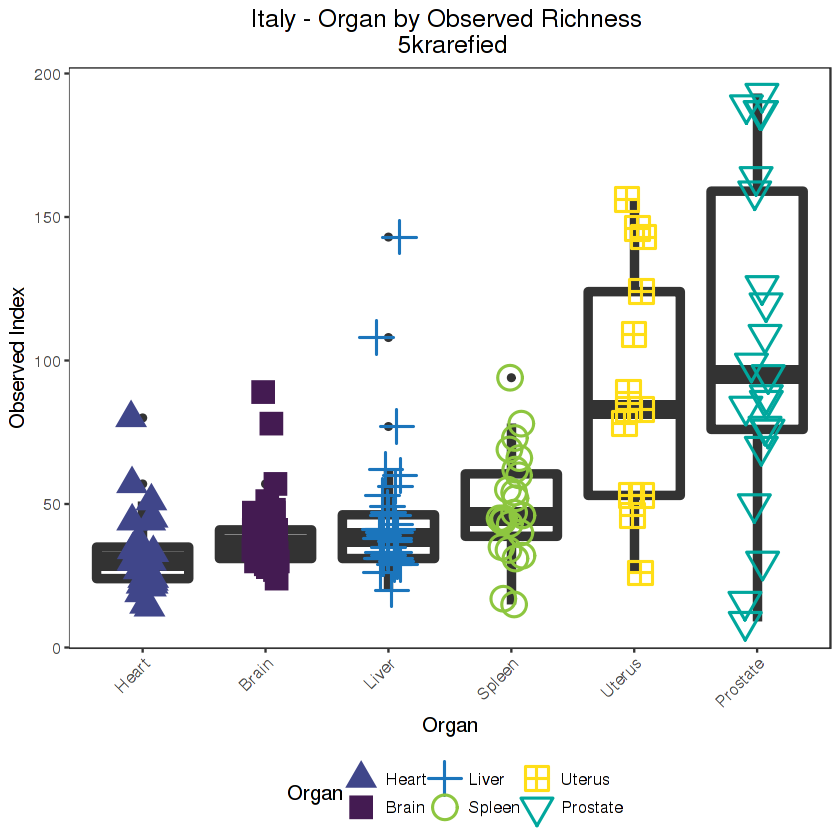

In [9]:
#Sort by mean
avg <- aggregate(Observed ~ Organ, data = dfobs, mean)
dfobs$Organ <-factor(dfobs$Organ, levels=avg[order(avg$Observed), "Organ"])

#Plot
p = ggplot(na.omit(dfobs), aes(x = Organ, y = Observed)) + ggtitle("Italy - Organ by Observed Richness \n 5krarefied")

p = p + geom_boxplot(lwd=2) + ylab("Observed Index") #+ ylim(0,250)

p = p + geom_point(size = 6,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1), aes(color=Organ,shape=Organ)) +
                   scale_shape_manual(values=c(17,15,3,1,12,6)) +
                   scale_color_manual(values=c("#40468A",
                                              "#441B52",
                                              "#1B75BC",
                                              "#8DC63F",
                                              "#FFDE17",
                                              "#00A79D"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

png('Italy_Organ_observed.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

In [10]:
#Shannon by organ

sample_tab = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/all_cadaver_metadata.csv")
colnames(sample_tab)[1] <- "SampleID"

sha = estimate_richness(na.omit(Ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Organ") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Organ")

stats.sha = dfsha %>%
    group_by(Organ) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) #%>%
    #arrange(-desc(mean))
stats.sha

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~Organ, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$Organ, method="bonferroni")
dunn

Organ,median,mean,sd,sem
Brain,1.990752,1.931587,0.4451773,0.0752487
Heart,1.725740,1.638765,0.7610086,0.1413157
Liver,1.806753,1.826702,0.6116528,0.1019421
Prostate,3.054951,2.794671,1.0881414,0.2374519
Spleen,2.183574,1.937450,0.8232785,0.1680510
Uterus,2.641988,2.700381,0.6858481,0.1902200



	Kruskal-Wallis rank sum test

data:  Shannon by Organ
Kruskal-Wallis chi-squared = 29.15, df = 5, p-value = 2.167e-05


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 29.1499, df = 5, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Brain      Heart      Liver   Prostate     Spleen
---------+-------------------------------------------------------
   Heart |   1.291842
         |     1.0000
         |
   Liver |   0.663490  -0.668842
         |     1.0000     1.0000
         |
Prostate |  -3.065380  -4.085080  -3.655063
         |    0.0163*    0.0003*    0.0019*
         |
  Spleen |  -0.376989  -1.537590  -0.976805   2.497309
         |     1.0000     0.9311     1.0000     0.0939
         |
  Uterus |  -2.942260  -3.835016  -3.440138  -0.310333  -2.484931
         |    0.0244*    0.0009*    0.0044*     1.0000     0.0972

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 29.14994

$Z
 [1]  1.2918427  0.6634908 -0.6688425 -3.0653807 -4.0850800 -3.6550630
 [7] -0.3769894 -1.5375902 -0.9768056  2.4973096 -2.9422607 -3.8350168
[13] -3.4401385 -0.3103336 -2.4849313

$P
 [1] 9.820581e-02 2.535081e-01 2.517980e-01 1.086965e-03 2.203082e-05
 [6] 1.285594e-04 3.530908e-01 6.207442e-02 1.643327e-01 6.256982e-03
[11] 1.629128e-03 6.277787e-05 2.907083e-04 3.781536e-01 6.478822e-03

$P.adjusted
 [1] 1.0000000000 1.0000000000 1.0000000000 0.0163044793 0.0003304622
 [6] 0.0019283909 1.0000000000 0.9311163577 1.0000000000 0.0938547308
[11] 0.0244369163 0.0009416680 0.0043606243 1.0000000000 0.0971823349

$comparisons
 [1] "Brain - Heart"     "Brain - Liver"     "Heart - Liver"    
 [4] "Brain - Prostate"  "Heart - Prostate"  "Liver - Prostate" 
 [7] "Brain - Spleen"    "Heart - Spleen"    "Liver - Spleen"   
[10] "Prostate - Spleen" "Brain - Uterus"    "Heart - Uterus"   
[13] "Liver - Uterus"    "Prostate - Uterus" "Spleen - Uterus"

png 
  2

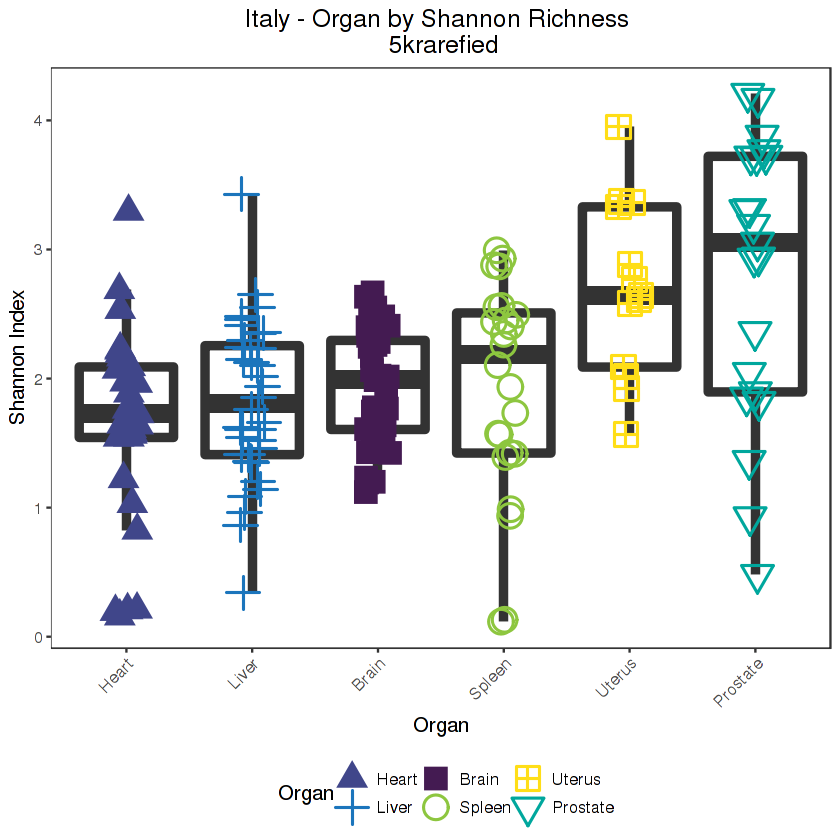

In [11]:
#Sort by mean
avg <- aggregate(Shannon ~ Organ, data = dfsha, mean)
dfsha$Organ <-factor(dfsha$Organ, levels=avg[order(avg$Shannon), "Organ"])

#Plot
p = ggplot(na.omit(dfsha), aes(x = Organ, y = Shannon)) + ggtitle("Italy - Organ by Shannon Richness \n 5krarefied")

p = p + geom_boxplot(lwd=2) + ylab("Shannon Index") #+ ylim(0,250)

p = p + geom_point(size = 6,alpha=1,stroke=1,
                   position = position_jitter(h = 0, w = 0.1), aes(color=Organ,shape=Organ)) +
                   scale_shape_manual(values=c(17,3,15,1,12,6))+
                   scale_color_manual(values=c("#40468A",
                                               "#1B75BC",
                                               "#441B52",
                                               "#8DC63F",
                                               "#FFDE17",
                                               "#00A79D"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

png('Italy_Organ_Shannon.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

In [14]:
dfobs.97 = subset(dfobs, PMI <97)

png 
  2

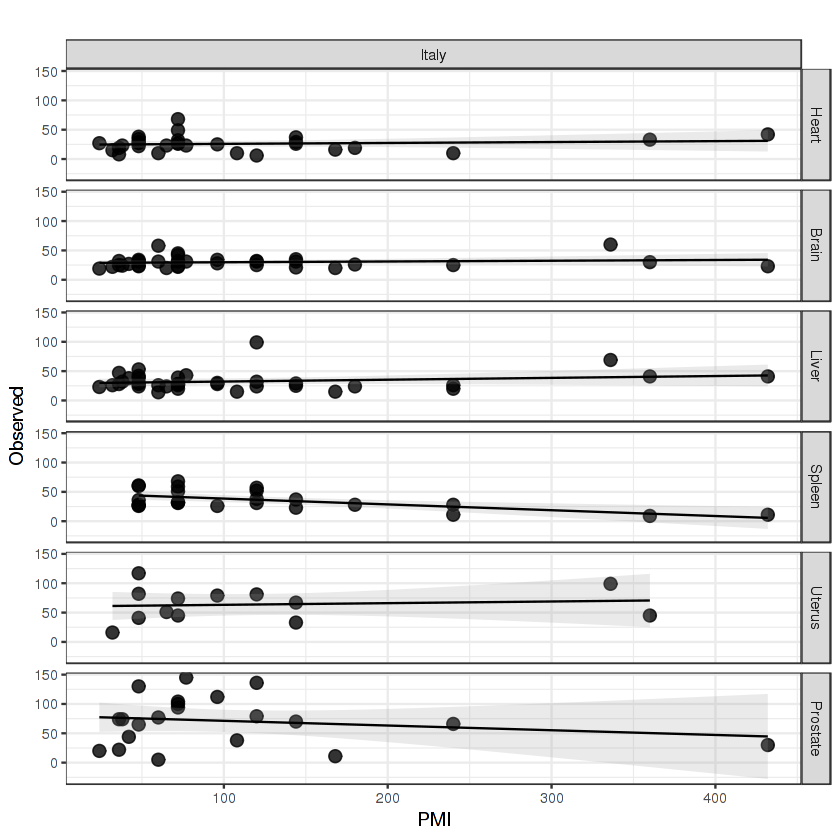

In [46]:
p = ggplot(dfobs, aes(x=PMI, y=Observed)) + geom_point(size = 3, alpha = .8) +  ggtitle("Observed by PMI - By Country")
p = p + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_bw() + theme(plot.title = element_text(hjust = 2))
p = p + facet_wrap(~Organ)
p

png('Observed.PMI.png', width=7.5, height=10, units='in', res=300)
plot(p)
dev.off()


png 
  2

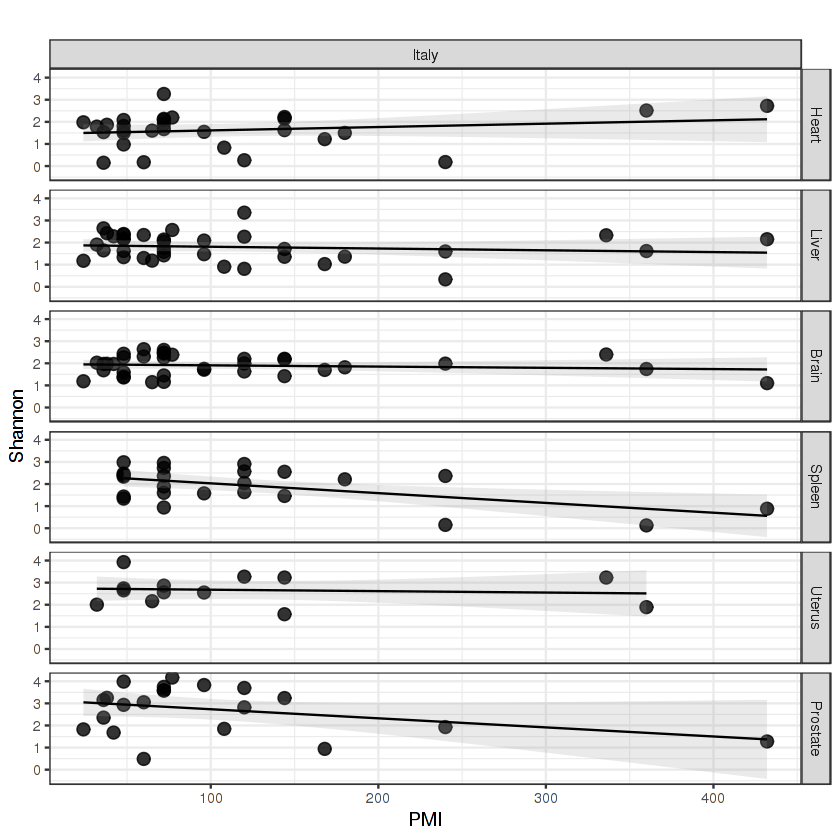

In [47]:
p = ggplot(dfsha, aes(x=PMI, y=Shannon)) + geom_point(size = 3, alpha = .8) +  ggtitle("Shannon by PMI - By Country")
p = p + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_bw() + theme(plot.title = element_text(hjust = 2)) 
p = p + facet_wrap(~Organ)
p

png('Shannon.PMI.png', width=7.5, height=10, units='in', res=300)
plot(p)
dev.off()


In [16]:
brain.ita = subset_samples(Ita, Organ=="Brain")
heart.ita = subset_samples(Ita, Organ=="Heart")
liver.ita = subset_samples(Ita, Organ=="Liver")
prostate.ita = subset_samples(Ita, Organ=="Prostate")
spleen.ita = subset_samples(Ita, Organ=="Spleen")
uterus.ita = subset_samples(Ita, Organ=="Uterus")

In [17]:
#brain
obs = estimate_richness(na.omit(brain.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
brain.dfobs.ita = merge(obs, sample_tab, on="SampleID")
brain.dfobs.ita.96 = subset(brain.dfobs.ita, PMI <97)
#heart
obs = estimate_richness(na.omit(heart.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
heart.dfobs.ita = merge(obs, sample_tab, on="SampleID")
heart.dfobs.ita.96 = subset(heart.dfobs.ita, PMI <97)
#liver
obs = estimate_richness(na.omit(liver.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
liver.dfobs.ita = merge(obs, sample_tab, on="SampleID")
liver.dfobs.ita.96 = subset(liver.dfobs.ita, PMI <97)
#prostate
obs = estimate_richness(na.omit(prostate.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
prostate.dfobs.ita = merge(obs, sample_tab, on="SampleID")
prostate.dfobs.ita.96 = subset(prostate.dfobs.ita, PMI <97)
#spleen
obs = estimate_richness(na.omit(spleen.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
spleen.dfobs.ita = merge(obs, sample_tab, on="SampleID")
spleen.dfobs.ita.96 = subset(spleen.dfobs.ita, PMI <97)
#uterus
obs = estimate_richness(na.omit(uterus.ita), split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
uterus.dfobs.ita = merge(obs, sample_tab, on="SampleID")
uterus.dfobs.ita.96 = subset(uterus.dfobs.ita, PMI <97)

In [23]:
#uterus
p1 = ggplot(uterus.dfobs.ita.96, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian uterus")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = uterus.dfobs.ita.96)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,2433.231,2433.231,1.25099,0.306134
Residuals,6,11670.269,1945.045,NA,NA



Call:
lm(formula = Observed ~ PMI, data = uterus.dfobs.ita.96)

Residuals:
   Min     1Q Median     3Q    Max 
-46.27 -27.03 -15.52  30.09  66.00 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  32.4483    52.2706   0.621    0.558
PMI           0.9281     0.8298   1.118    0.306

Residual standard error: 44.1 on 6 degrees of freedom
Multiple R-squared:  0.1725,	Adjusted R-squared:  0.03461 
F-statistic: 1.251 on 1 and 6 DF,  p-value: 0.3061


In [52]:
#heart
p1 = ggplot(heart.dfobs.ita, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian heart")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = heart.dfobs.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,61.34683,61.34683,0.3466925,0.5608857
Residuals,27,4777.61868,176.94884,NA,NA



Call:
lm(formula = Observed ~ PMI, data = heart.dfobs.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.166  -8.094  -0.537   3.947  42.576 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 24.31032    3.74219   6.496 5.79e-07 ***
PMI          0.01546    0.02626   0.589    0.561    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.3 on 27 degrees of freedom
Multiple R-squared:  0.01268,	Adjusted R-squared:  -0.02389 
F-statistic: 0.3467 on 1 and 27 DF,  p-value: 0.5609


In [53]:
#liver
p1 = ggplot(liver.dfobs.ita, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian liver")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = liver.dfobs.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,327.0719,327.0719,1.30779,0.2607833
Residuals,34,8503.2336,250.0951,NA,NA



Call:
lm(formula = Observed ~ PMI, data = liver.dfobs.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.398  -7.546  -3.397   3.087  66.102 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.14726    4.03352   7.226 2.31e-08 ***
PMI          0.03125    0.02733   1.144    0.261    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.81 on 34 degrees of freedom
Multiple R-squared:  0.03704,	Adjusted R-squared:  0.008717 
F-statistic: 1.308 on 1 and 34 DF,  p-value: 0.2608


In [54]:
#spleen
p1 = ggplot(spleen.dfobs.ita, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian spleen")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = spleen.dfobs.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,2285.355,2285.3546,12.26743,0.002012048
Residuals,22,4098.479,186.2945,NA,NA



Call:
lm(formula = Observed ~ PMI, data = spleen.dfobs.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.691 -10.532  -3.204  11.124  26.686 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 48.44526    4.53405  10.685 3.57e-10 ***
PMI         -0.09904    0.02828  -3.502  0.00201 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.65 on 22 degrees of freedom
Multiple R-squared:  0.358,	Adjusted R-squared:  0.3288 
F-statistic: 12.27 on 1 and 22 DF,  p-value: 0.002012


In [55]:
#prostate
p1 = ggplot(prostate.dfobs.ita, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian prostate")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = prostate.dfobs.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,1095.737,1095.737,0.6335266,0.435897
Residuals,19,32862.073,1729.583,NA,NA



Call:
lm(formula = Observed ~ PMI, data = prostate.dfobs.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-69.500 -31.945   2.246  26.464  71.865 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  79.3181    13.6166   5.825  1.3e-05 ***
PMI          -0.0803     0.1009  -0.796    0.436    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 41.59 on 19 degrees of freedom
Multiple R-squared:  0.03227,	Adjusted R-squared:  -0.01867 
F-statistic: 0.6335 on 1 and 19 DF,  p-value: 0.4359


In [56]:
#uterus
p1 = ggplot(uterus.dfobs.ita, aes(x=PMI, y=Observed)) + geom_point() +  ggtitle("Observed by PMI - Italian uterus")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Observed ~ PMI, data = uterus.dfobs.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,110.3831,110.3831,0.1270722,0.7282306
Residuals,11,9555.3092,868.6645,NA,NA



Call:
lm(formula = Observed ~ PMI, data = uterus.dfobs.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.292 -20.747   2.527  17.208  55.253 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 60.38364   12.69520   4.756 0.000594 ***
PMI          0.02840    0.07967   0.356 0.728231    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 29.47 on 11 degrees of freedom
Multiple R-squared:  0.01142,	Adjusted R-squared:  -0.07845 
F-statistic: 0.1271 on 1 and 11 DF,  p-value: 0.7282


In [57]:
#brain
sha = estimate_richness(na.omit(brain.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
brain.dfsha.ita = merge(sha, sample_tab, on="SampleID")
#heart
sha = estimate_richness(na.omit(heart.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
heart.dfsha.ita = merge(sha, sample_tab, on="SampleID")
#liver
sha = estimate_richness(na.omit(liver.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
liver.dfsha.ita = merge(sha, sample_tab, on="SampleID")
#prostate
sha = estimate_richness(na.omit(prostate.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
prostate.dfsha.ita = merge(sha, sample_tab, on="SampleID")
#spleen
sha = estimate_richness(na.omit(spleen.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
spleen.dfsha.ita = merge(sha, sample_tab, on="SampleID")
#uterus
sha = estimate_richness(na.omit(uterus.ita), split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
uterus.dfsha.ita = merge(sha, sample_tab, on="SampleID")

In [58]:
#Brain
p1 = ggplot(brain.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian Brain")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = brain.dfsha.ita)
anova(fit)
summary(fit)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,0.09958111,0.09958111,0.4917945,0.4880441
Residuals,33,6.68201127,0.20248519,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = brain.dfsha.ita)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.77912 -0.30630  0.02963  0.33433  0.70785 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.9637059  0.1161314  16.909   <2e-16 ***
PMI         -0.0005606  0.0007994  -0.701    0.488    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.45 on 33 degrees of freedom
Multiple R-squared:  0.01468,	Adjusted R-squared:  -0.01517 
F-statistic: 0.4918 on 1 and 33 DF,  p-value: 0.488


In [59]:
#heart
p1 = ggplot(heart.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian heart")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = heart.dfsha.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,0.5933172,0.5933172,1.032049,0.3186955
Residuals,27,15.5220996,0.5748926,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = heart.dfsha.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6450 -0.2363  0.1011  0.5044  1.6912 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.461124   0.213302   6.850 2.33e-07 ***
PMI         0.001521   0.001497   1.016    0.319    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7582 on 27 degrees of freedom
Multiple R-squared:  0.03682,	Adjusted R-squared:  0.001143 
F-statistic: 1.032 on 1 and 27 DF,  p-value: 0.3187


In [60]:
#liver
p1 = ggplot(liver.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian liver")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = liver.dfsha.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,0.2162949,0.2162949,0.5742559,0.4537932
Residuals,34,12.8061844,0.3766525,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = liver.dfsha.ita)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36278 -0.41369 -0.02564  0.47636  1.55834 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.8916517  0.1565315  12.085  7.4e-14 ***
PMI         -0.0008037  0.0010606  -0.758    0.454    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6137 on 34 degrees of freedom
Multiple R-squared:  0.01661,	Adjusted R-squared:  -0.01231 
F-statistic: 0.5743 on 1 and 34 DF,  p-value: 0.4538


In [61]:
#spleen
p1 = ggplot(spleen.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian spleen")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = spleen.dfsha.ita)
anova(fit)
summary(fit)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,4.569817,4.5698165,9.352182,0.005761383
Residuals,22,10.750001,0.4886364,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = spleen.dfsha.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2597 -0.4910  0.1232  0.5853  0.9631 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.473932   0.232209  10.654 3.77e-10 ***
PMI         -0.004429   0.001448  -3.058  0.00576 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.699 on 22 degrees of freedom
Multiple R-squared:  0.2983,	Adjusted R-squared:  0.2664 
F-statistic: 9.352 on 1 and 22 DF,  p-value: 0.005761


In [62]:
#prostate
p1 = ggplot(prostate.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian prostate")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = prostate.dfsha.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,2.865004,2.865004,2.70895,0.1162284
Residuals,19,20.094525,1.057607,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = prostate.dfsha.ita)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4117 -0.6419  0.1561  0.7392  1.3384 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.144928   0.336714   9.340 1.56e-08 ***
PMI         -0.004106   0.002495  -1.646    0.116    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.028 on 19 degrees of freedom
Multiple R-squared:  0.1248,	Adjusted R-squared:  0.07872 
F-statistic: 2.709 on 1 and 19 DF,  p-value: 0.1162


In [63]:
#uterus
p1 = ggplot(uterus.dfsha.ita, aes(x=PMI, y=Shannon)) + geom_point() +  ggtitle("Shannon by PMI - Italian uterus")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

fit = lm(Shannon ~ PMI, data = uterus.dfsha.ita)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,0.05681286,0.05681286,0.1226083,0.7328353
Residuals,11,5.09705686,0.46336881,NA,NA



Call:
lm(formula = Shannon ~ PMI, data = uterus.dfsha.ita)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.08055 -0.54186 -0.06293  0.57842  1.21468 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.7448530  0.2932088   9.361 1.42e-06 ***
PMI         -0.0006443  0.0018400  -0.350    0.733    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6807 on 11 degrees of freedom
Multiple R-squared:  0.01102,	Adjusted R-squared:  -0.07888 
F-statistic: 0.1226 on 1 and 11 DF,  p-value: 0.7328
